In [5]:
import glob
import gsw
import warnings
import xarray as xr
import cftime
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import os
import zarr

<xarray.Dataset> Size: 1MB
Dimensions:      (trajectory: 24, obs: 1021)
Coordinates:
  * obs          (obs) int32 4kB 0 1 2 3 4 5 6 ... 1015 1016 1017 1018 1019 1020
  * trajectory   (trajectory) int64 192B 38 39 40 41 42 43 ... 56 57 58 59 60 61
Data variables:
    lat          (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    lon          (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    max_depth    (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    min_depth    (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    raising      (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    salinity     (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    temperature  (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    time         (trajectory, obs) datetime64[ns] 196kB dask.array<chunk

C:\Users\gvp63\AppData\Local\Temp\ipykernel_27620\3860397322.py:13: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  num_trajectories = ds.dims['trajectory']
C:\Users\gvp63\AppData\Local\Temp\ipykernel_27620\3860397322.py:14: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  num_observations = ds.dims['obs']


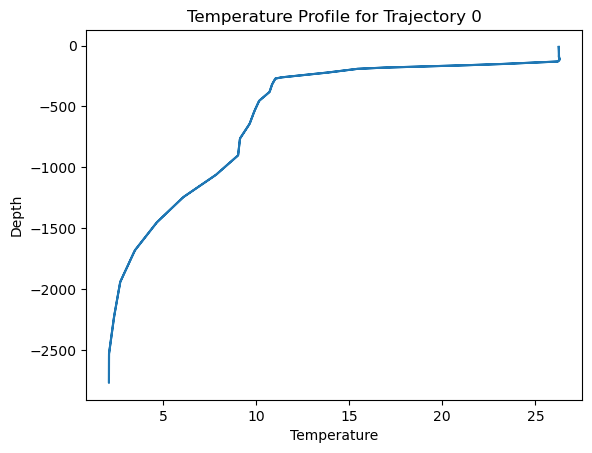

C:\Users\gvp63\AppData\Local\Temp\ipykernel_27620\3860397322.py:29: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for trajectory in range(ds.dims['trajectory']):
C:\Users\gvp63\AppData\Local\Temp\ipykernel_27620\3860397322.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for obs in range(ds.dims['obs']):
C:\Users\gvp63\AppData\Local\Temp\ipykernel_27620\3860397322.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, 

{'lat': array(5.029581, dtype=float32), 'lon': array(49.447758, dtype=float32), 'time': np.datetime64('2024-09-17T23:12:00.000000000'), 'temperature': array(26.256418, dtype=float32), 'salinity': array(34.966347, dtype=float32), 'z': array(-11., dtype=float32)}


In [36]:
# Open the Zarr dataset
datadir = r"C:\Users\gvp63\Downloads\results (2)\somalia\results\ctd.zarr"
ds = xr.open_zarr(datadir)

# Inspect the dataset
print(ds)

# Access data for a specific trajectory and observation
profile = ds.isel(trajectory=0, obs=0)
print(profile)

# Count the number of trajectories and observations
num_trajectories = ds.dims['trajectory']
num_observations = ds.dims['obs']
print(f"Number of trajectories: {num_trajectories}")
print(f"Number of observations per trajectory: {num_observations}")

# Plot temperature vs depth for the first trajectory
plt.plot(ds['temperature'].isel(trajectory=0), ds['z'].isel(trajectory=0))
plt.xlabel('Temperature')
plt.ylabel('Depth')
plt.title('Temperature Profile for Trajectory 0')
plt.show()

# Define data as a list of profiles
data = []

# Iterate over trajectories and observations
for trajectory in range(ds.dims['trajectory']):
    for obs in range(ds.dims['obs']):
        # Extract profile data
        profile = ds.isel(trajectory=trajectory, obs=obs)
        data.append({
            'lat': profile['lat'].values,
            'lon': profile['lon'].values,
            'time': profile['time'].values,
            'temperature': profile['temperature'].values,
            'salinity': profile['salinity'].values,
            'z': profile['z'].values
        })

# Check the first profile
print(data[0])

c:\Users\gvp63\anaconda3\envs\dyoc\Lib\site-packages\shapely\creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


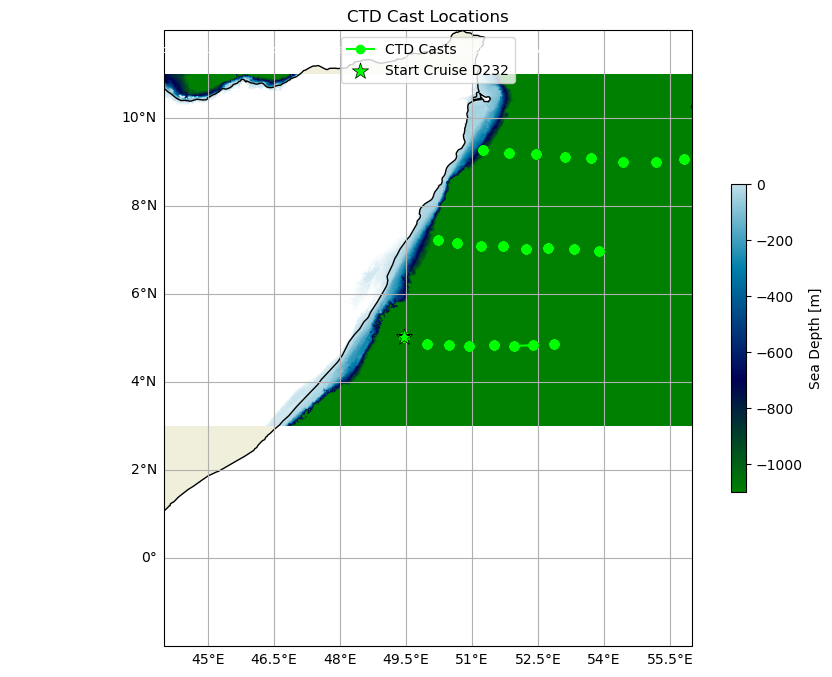

In [37]:
# Load bathymetry data
bathy = xr.open_dataset(r"C:\Users\gvp63\Downloads\gebco_2024_n11.0_s3.0_w44.0_e57.0.nc")

# Create the plot
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot bathymetry
tp = ax.pcolormesh(bathy.lon, bathy.lat, bathy.elevation, cmap='ocean', vmin=-1100, vmax=100, transform=ccrs.PlateCarree())

# Add features
ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
ax.add_feature(cfeature.LAND.with_scale('10m'))
ax.gridlines(draw_labels=['left', 'bottom'], zorder=0)

# Plot CTD cast locations
if data:
    ax.plot([profile['lon'] for profile in data], [profile['lat'] for profile in data], '-o',
            transform=ccrs.PlateCarree(), c='lime', label='CTD Casts')
    ax.scatter(data[0]['lon'], data[0]['lat'], c='lime', marker='*', s=150, zorder=2,
               transform=ccrs.PlateCarree(), edgecolors='k', linewidths=.5, label='Start Cruise D232')
    ax.legend(loc='upper center')
else:
    print("Warning: No CTD data found. Skipping CTD cast locations.")

# Set title and extent
ax.set_title('CTD Cast Locations')
ax.set_extent([44, 56, -2, 12])  # [min_lon, max_lon, min_lat, max_lat]

# Add colorbar
cb = fig.colorbar(tp, ax=ax, shrink=.5)
cb.ax.set_ylim([-1100, 0])
cb.set_label('Sea Depth [m]')

info_text = bathy.attrs.get('title', 'GEBCO 2024 Grid')  # Use 'title' or another available attribute
_ = ax.text(40.5, 11.5, info_text, c='w', fontsize=8)  # Adjust position as needed

plt.show()

In [44]:
alpha_T= 1*10**(-4)
beta_S= 7*10**(-4)
dens0 = 1027
import numpy as np
import matplotlib.pyplot as plt

# Constants
alpha_T = 1 * 10**(-4)  # Thermal expansion coefficient
beta_S = 7 * 10**(-4)   # Haline contraction coefficient
dens0 = 1027             # Reference density (kg/m³)

def calc_density(profile):
    """
    Calculate density from a profile containing salinity, temperature, and depth.
    
    Parameters:
        profile (dict): A dictionary containing 'salinity', 'temperature', and 'z' keys.
    """
    # Extract salinity, temperature, and depth
    S = profile['salinity']  # Salinity values
    T = profile['temperature']  # Temperature values
    depth = profile['z']  # Depth values

    # Reference salinity and temperature
    S0 = S[0]  # Reference salinity (first value)
    T0 = T[0]  # Reference temperature (first value)

    # Create empty array for storage
    dens = np.zeros_like(S)

    # Calculate density
    for i in range(len(S)):  # Loop over observations
        dens[i] = dens0 * (1 - (alpha_T * (T[i] - T0)) + (beta_S * (S[i] - S0)))

    # Plot density vs depth
    plt.plot(dens, -depth)  # Use depth on the y-axis
    plt.grid()
    plt.title('Density vs Depth')
    plt.ylabel('Depth (m)')
    plt.xlabel('Density (kg/m³)')
    plt.show()

    return dens

In [45]:
for j in range(len(data)):
    calc_density(data[j])

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed